In [19]:
import sys
path = '/lustre/home/pr5739/qualikiz/UKAEAGroupProject/src/'
path2 = '/lustre/home/pr5739/qualikiz/UKAEAGroupProject/src/scripts'
sys.path.append(path)
sys.path.append(path2)
import numpy as np 
import pandas as pd
import h5py as h5
import seaborn as sns

plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['axes.linewidth']=5
plt.rcParams['xtick.major.size'] =15

plt.rcParams['ytick.major.size'] =15
plt.rcParams['xtick.minor.size'] =10
plt.rcParams['ytick.minor.size'] =10
plt.rcParams['xtick.major.width'] =5
plt.rcParams['ytick.major.width'] =5
plt.rcParams['xtick.minor.width'] =5
plt.rcParams['ytick.minor.width'] =5
plt.rcParams['axes.titlepad'] = 10

plt.rcParams['font.size']=55
plt.rcParams['figure.figsize']=(10,10)


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score
import torch
from scripts.utils import train_keys
from scripts.Classifier import Classifier, ClassifierDataset
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import comet_ml

from pytorch_lightning.loggers import CometLogger
from sklearn.preprocessing import StandardScaler

In [2]:
datapath = "/lustre/home/pr5739/qualikiz/UKAEAGroupProject"

# Analysis

In [4]:
checkpoint = f'{path}/../logs/ITG_TEM/correct_checkpoints/experiment_name=0-epoch=26-val_acc=0.94.ckpt'
#1/experiment_name=0-epoch=48-val_loss=0.46.ckpt'
model = Classifier.load_from_checkpoint(checkpoint)

In [5]:
train = pd.read_pickle(f'{datapath}/data/ITG_TEM/train.pkl')
val = pd.read_pickle(f'{datapath}/data/ITG_TEM/valid.pkl')
test = pd.read_pickle(f'{datapath}/data/ITG_TEM/test.pkl')    


In [6]:
X_train = train[train_keys]
Y_train = train['turb_type']
X_val = val[train_keys]
Y_val = val['turb_type']
X_test = test[train_keys]
Y_test = test['turb_type']

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [8]:
#ds_test = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(Y_test).int())
#dl_test = torch.utils.data.DataLoader(ds_test, batch_size=256, shuffle=False, num_workers=16)

predictions = model(torch.tensor(X_test, dtype=torch.float)).detach().numpy()


In [14]:
test_pred = np.argmax(predictions,axis=1)


In [15]:
n_0 = np.where(Y_test ==0)[0].shape[0]
n_1 = np.where(Y_test ==1)[0].shape[0]
n_2 = np.where(Y_test ==2)[0].shape[0]
div_arr = np.array([[n_0, n_1, n_2]]).T

### metrics

In [22]:
accuracy = accuracy_score(Y_test, test_pred)
F1 = f1_score(Y_test, test_pred, labels=[0,1,2], average='micro')
precision = precision_score(Y_test, test_pred,labels=[0,1,2], average='micro')
recall =recall_score(Y_test,test_pred,labels=[0,1,2], average='micro')

print('For test set:')
print(f'accuracy: {accuracy}\nF1; {F1}\nprecision: {precision}\nrecall:{recall}')

For test set:
accuracy: 0.9325782144811361
F1; 0.9325782144811361
precision: 0.9325782144811361
recall:0.9325782144811361


In [23]:
fpr,tpr,_ = roc_curve(Y_test,predictions)
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
print(f'ROC AUC:{roc_auc_score(Y_test,test_pred)}')

ValueError: multiclass format is not supported

[Text(0.5, 1.0, 'Confusion Matrix'),
 Text(0.5, 15.0, 'Predicted'),
 Text(33.0, 0.5, 'Actual')]

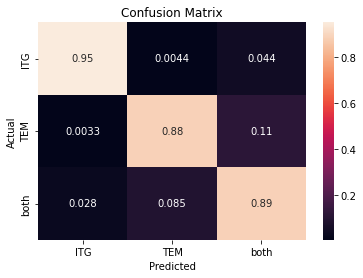

In [18]:
con_mat = confusion_matrix(Y_test, test_pred, labels =[0,1,2])/div_arr
sns.heatmap(con_mat, annot=True, xticklabels=['ITG','TEM','both'], yticklabels=['ITG','TEM','both']).set(title='Confusion Matrix', xlabel='Predicted', ylabel='Actual')